------------------------------------------------------------------------------------------------

<h3>Dataset: </h3>
Diabetes

<h3>Objective: </h3>
Build a classification model to predict the risk of diabetes based on diagnostic measurements.

------------------------------------------------------------------------------------------------

Loading the dataset from - https://www.kaggle.com/mathchi/diabetes-data-set.
The requirement here is to make a classification model that detects the risk of diabetes based on some medical parameters.

**Columns**
*  **Pregnancies:** Number of times pregnant
*  **Glucose:** Plasma glucose concentration a 2 hours in an oral glucose tolerance test
*  **BloodPressure:** Diastolic blood pressure (mm Hg)
*  **SkinThickness:** Triceps skin fold thickness (mm)
*  **Insulin:** 2-Hour serum insulin (mu U/ml) 
*  **BMI:** Body mass index (weight in kg/(height in m)^2)
*  **DiabetesPedigreeFunction:** Diabetes pedigree function (a function which scores likelihood of diabetes based on family history) 
*  **Age:** Age (years)
*  **Outcome:** Class variable (0 or 1)

### Import Libraries

In [1]:
# import basic libraries
import pandas as pd
import numpy as np
import math

# import libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# import libraries for data encoding, normalization and standarization
try:
    import category_encoders as ce
except:
    !pip install category_encoders
    import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler

# import library for missing values imputation
from sklearn.linear_model import LinearRegression

# import library for sampling
try:
    from imblearn.over_sampling import SMOTE
except:
    !pip install imblearn
    from imblearn.over_sampling import SMOTE

# import libraries for modeling
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# import libraries for model performance evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss

### Reusable Functions

#### Function to generate a clean (lower triangular) heatmap visual

In [2]:
def show_heat_map(data):
    """
    function show_heat_map() to generate a heatmap for showing a correlation between features
    Input(s): 
        - data: as dataframe
    Output(s):
        - None
    """
    corr_matrix = data.corr()
    # mask the upper triangle
    plt.figure(figsize=(12, 10))
    mask = np.zeros_like(corr_matrix, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(data.corr(), mask=mask, annot=True)

#### Function to identify outliers in input feature using Z-score

In [3]:
def identify_outliers_Zscore(data, feature):
    """
    function identify_outliers_Zscore() to identify the outliers in input dataframe
    Method: Z-score, permissible values bounded within -3 <= z-score <= 3
    Input(s): 
        - data: as dataframe
        - feature: feature on which outliers are to be identified
    Output(s):
        - indices - list of indexes of the outliers
    """
    mean = np.mean(data[feature])
    std_dev = np.std(data[feature])
    indices = []
    for index, value in data[feature].iteritems():
        z_score = (value-mean)/std_dev
        if abs(z_score) > 3:
            indices.append(index)
    return indices

#### Function to create a stacked histogram

In [4]:
def show_stacked_histogram(dimension, category):
    """
    function show_stacked_histogram() to create and print a stacked histogram
    Method: uses seaborn library, histplot function
    Input(s): 
        - dimension: feature to be plottled on x-axis
        - category: feature to be used for stacking the histogram bars
    Output(s):
        - none
    """
    f = plt.figure(figsize=(8,6))
    ax = f.add_subplot()
    plt.xticks(rotation=45)
    sns.histplot(x=dimension, hue=category, multiple="stack")
    plt.show()

#### Function to print a plot of skewness of columns in dataframe

In [5]:
# Print a line chart between skewness and column
def show_skewness(df):
    skew = {}
    num_col = df.columns
    print(df.skew())
    for i in num_col:
        skew[i] = df[i].skew()
        plt.rcParams["figure.figsize"] = [8,4]
        plt.plot(list(skew.keys()),list(skew.values()))
        plt.xticks(rotation=45, horizontalalignment='right')
    plt.show()
    return

### Import Dataset

In [6]:
# load the dataset
diabetes = pd.read_csv('diabetes.csv')

------------------------------------------------------------------------------------------------

### 2. Data Exploration & Visualization

#### Print first 5 and last 5 rows in the dataset

In [7]:
# view first 5 rows in dataset
diabetes.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [8]:
# view last 5 rows in dataset
diabetes.tail(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1
767,1,93,70,31,0,30.4,0.315,23,0


#### Print the description and shape of the dataset

In [9]:
# view the basic statistical details of numerical features
diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [10]:
# view the shape of dataset
print(diabetes.shape)
print('\nThe given dataset has {} rows and {} columns'.format(diabetes.shape[0], diabetes.shape[1]))

(768, 9)

The given dataset has 768 rows and 9 columns


In [11]:
# view summary of dataset
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [12]:
# view the unique values for features and their respective counts
for v in diabetes:
    print ("\n----- %s -----" % v)
    print (diabetes[v].value_counts())


----- Pregnancies -----
1     135
0     111
2     103
3      75
4      68
5      57
6      50
7      45
8      38
9      28
10     24
11     11
13     10
12      9
14      2
15      1
17      1
Name: Pregnancies, dtype: int64

----- Glucose -----
99     17
100    17
129    14
125    14
106    14
       ..
169     1
61      1
178     1
177     1
199     1
Name: Glucose, Length: 136, dtype: int64

----- BloodPressure -----
70     57
74     52
78     45
68     45
72     44
64     43
80     40
76     39
60     37
0      35
62     34
82     30
66     30
88     25
84     23
90     22
58     21
86     21
50     13
56     12
54     11
52     11
92      8
75      8
65      7
85      6
94      6
48      5
96      4
44      4
110     3
106     3
100     3
98      3
108     2
104     2
46      2
55      2
30      2
95      1
61      1
102     1
38      1
40      1
24      1
114     1
122     1
Name: BloodPressure, dtype: int64

----- SkinThickness -----
0     227
32     31
30     27
27     23
23 

#### Next, we will plot a histogram of all features to see their distribution in dataset w.r.t. Outcome

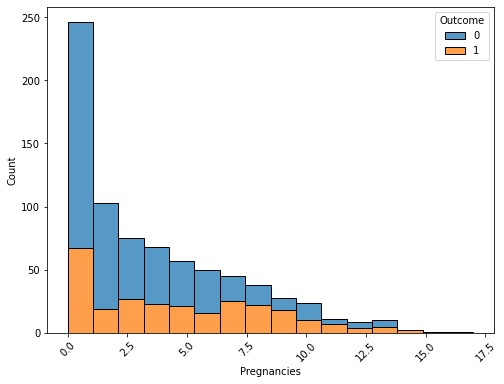

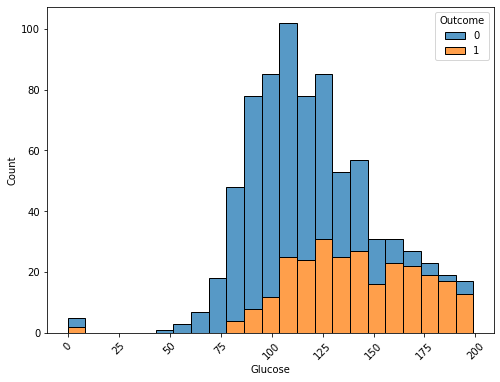

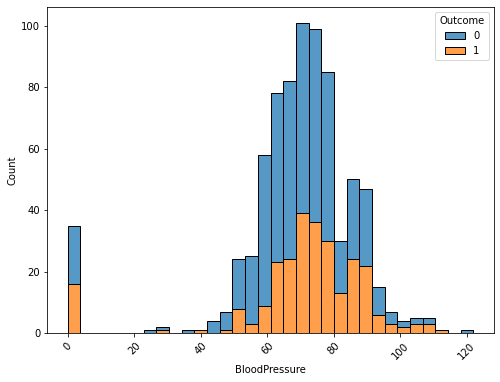

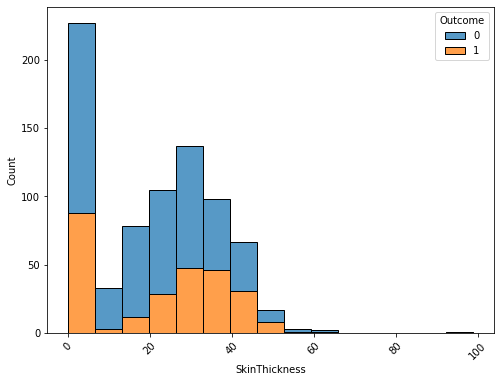

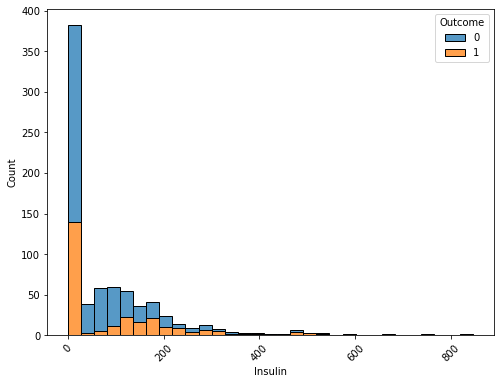

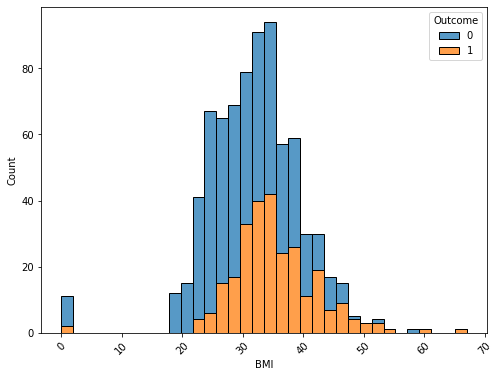

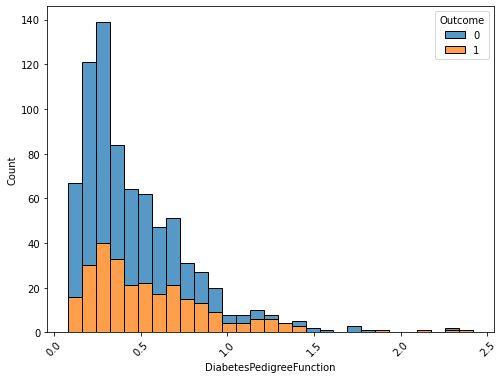

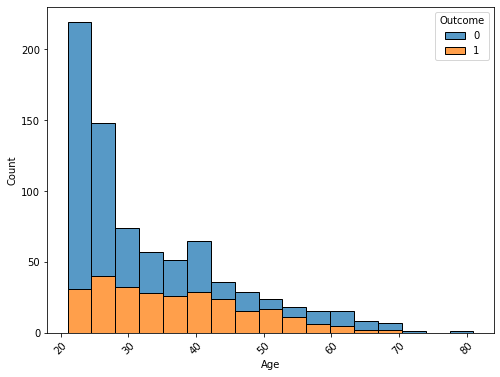

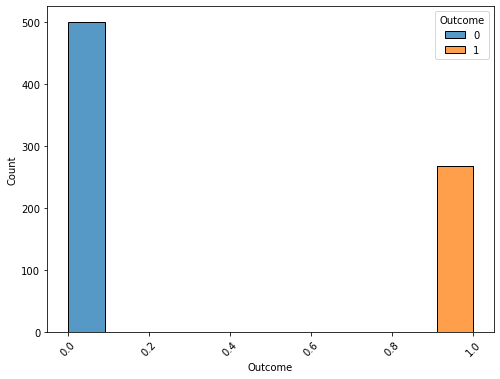

In [13]:
# plot histogram of all the features stacked by Outcome
for v in diabetes.columns:
    show_stacked_histogram(diabetes[v], diabetes['Outcome'])

#### Print a boxplot of numerical features to review outliers

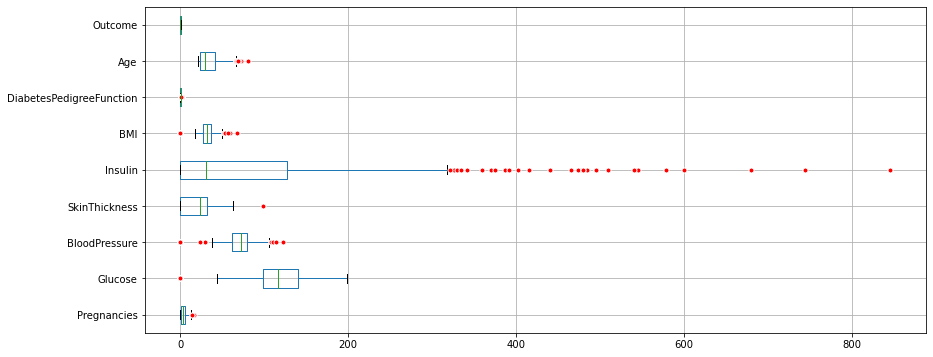

In [14]:
# boxplot to check the distribution of numerical features
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white',  markersize=5)
diabetes.boxplot(figsize=(14,6), flierprops=red_circle, vert=False)
plt.show()

#### Check and plot the skewness of data in features

Pregnancies                 0.901674
Glucose                     0.173754
BloodPressure              -1.843608
SkinThickness               0.109372
Insulin                     2.272251
BMI                        -0.428982
DiabetesPedigreeFunction    1.919911
Age                         1.129597
Outcome                     0.635017
dtype: float64


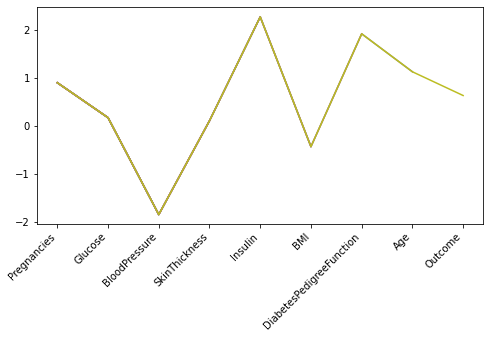

In [15]:
# visualize the skewness of data
show_skewness(diabetes)

#### Review the correlation between the numerical features 

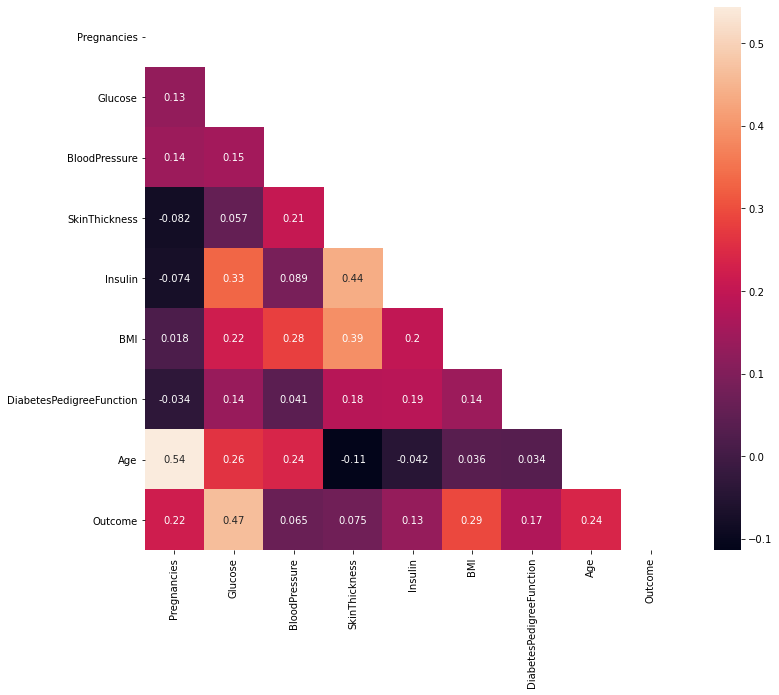

In [16]:
# show the correlation between the features
show_heat_map(diabetes)

------------------------------------------------------------------------------------------------

### Data Pre-Processing and Cleaning

#### 1. Identify null or missing values

In [17]:
# check if the features have null values
diabetes.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

During data exploration, we found that few features in dataset have a 0 value. Let’s find those features and get the count of 0 values present in them.

In [18]:
# find the features having 0 value and respective counts
for col in diabetes.columns :
    print(col, " \t : {:d}".format(diabetes[col][diabetes[col] ==0].count()))

Pregnancies  	 : 111
Glucose  	 : 5
BloodPressure  	 : 35
SkinThickness  	 : 227
Insulin  	 : 374
BMI  	 : 11
DiabetesPedigreeFunction  	 : 0
Age  	 : 0
Outcome  	 : 500


#### 2. Handle missing values

We will handle the missing values using imputation:
1. Mean Imputation: BMI and Glucose have skewness within acceptable range i.e. close to 0.5, hence we shall be doing Mean imputation
2. Median Imputation: BloodPressure is negatively skewed above the acceptable range i.e. -1.84, hence we shall be performing Median imputation

In [19]:
# replace 0 value with NaN
diabetes['BMI'] = diabetes['BMI'].replace(0, np.nan) 
diabetes['Glucose'] = diabetes['Glucose'].replace(0, np.nan) 
diabetes['BloodPressure'] = diabetes['BloodPressure'].replace(0, np.nan) 

# impute BMI and Glucose with mean
diabetes['BMI']=diabetes['BMI'].fillna(diabetes['BMI'].mean())
diabetes['Glucose']=diabetes['Glucose'].fillna(diabetes['Glucose'].mean())

# impute BloodPressure with median
diabetes['BloodPressure']=diabetes['BloodPressure'].fillna(diabetes['BloodPressure'].median())

Since Insulin and SkinThickness have large number of missing values, we will use Linear Regression Prediction Technique to impute the missing values in them. For predicting their missing values, we shall be using Linear Regression with other attributes (below) that do not have missing values.

In [20]:
# creating a temporary copy of the dataset diabetes for intermediate operations
data = diabetes[['Pregnancies','BloodPressure','Insulin','BMI','Age','DiabetesPedigreeFunction','Outcome','Glucose']]

# get the column names
cols = diabetes.columns

In [21]:
# ignore warnings during dataframe copy
import warnings
warnings.filterwarnings('ignore')

# impute missing values in Insulin feature
data['Insulin'] = data['Insulin'].replace(0, np.nan)

test_data = data[data.isnull().any(axis=1)]
data.dropna(inplace=True)

x_train = data.drop('Insulin', axis=1)
y_train = data['Insulin']
x_test  = test_data.drop('Insulin', axis=1)

model = LinearRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
x_test['Insulin'] = y_pred

filled_dataset=x_test
filled_dataset['Insulin'] = y_pred
data = data.append(filled_dataset)

In [22]:
# check for any presence of 0 in Insulin feature
data.Insulin.value_counts().sort_index()

-21.696341     1
 1.936554      1
 14.000000     1
 15.000000     1
 16.000000     1
              ..
 579.000000    1
 600.000000    1
 680.000000    1
 744.000000    1
 846.000000    1
Name: Insulin, Length: 559, dtype: int64

In [23]:
# remove any rows with insulin value less than 0 - as its not natural for any human
data.drop(data[data['Insulin'] < 0].index, inplace = True)

In [24]:
# impute missing values in SkinThickness feature
data['SkinThickness'] = diabetes.SkinThickness
data['SkinThickness'] = data['SkinThickness'].replace(0, np.nan)

test_data = data[data.isnull().any(axis=1)]
data.dropna(inplace=True)

x_train = data.drop('SkinThickness', axis=1)
y_train = data['SkinThickness']
x_test  = test_data.drop('SkinThickness', axis=1)

model = LinearRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
x_test['SkinThickness'] = y_pred

filled_dataset=x_test
filled_dataset['SkinThickness'] = y_pred
data = data.append(filled_dataset)

In [25]:
# copy imputed dataframe into diabetes dataframe
diabetes = data

# remove temporary dataframe from memory
del data

In [26]:
# Checking presence of 0 in SkinThickness feature
diabetes.SkinThickness.value_counts().sort_index() 

7.0     2
8.0     2
10.0    5
11.0    6
12.0    7
       ..
54.0    2
56.0    1
60.0    1
63.0    1
99.0    1
Name: SkinThickness, Length: 276, dtype: int64

In [27]:
# reorder the columns in same order as that of original dataframe
diabetes = diabetes.reindex(columns=cols)

#### 3. Identify outliers and remove

During exploration, we observed that there are outliers in numerical features. Let's check that again for numerical features in the updated dataset.

Let's view the boxplot to visualize the outliers.


Boxplot of numerical features:


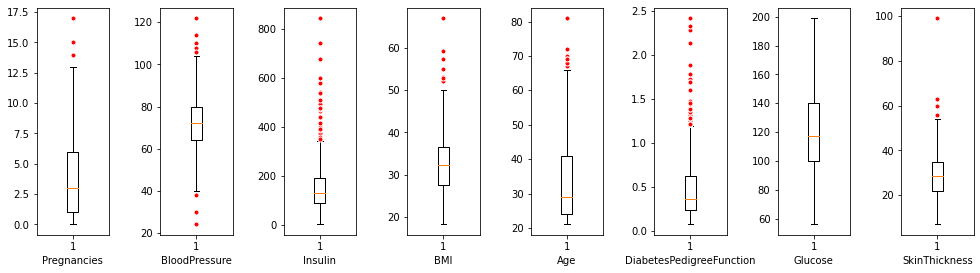

In [28]:
# print boxplot to check the distribution of numerical features

print("\nBoxplot of numerical features:")

red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white',  markersize=5)
fig, ([ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]) = plt.subplots(1, 8, figsize=(14,4))
fig.tight_layout(pad=2) # for distance between the sub-plots

ax1.boxplot(diabetes.Pregnancies, flierprops=red_circle)
ax1.set_xlabel('Pregnancies')

ax2.boxplot(diabetes.BloodPressure, flierprops=red_circle)
ax2.set_xlabel('BloodPressure')

ax3.boxplot(diabetes.Insulin, flierprops=red_circle)
ax3.set_xlabel('Insulin')

ax4.boxplot(diabetes.BMI, flierprops=red_circle)
ax4.set_xlabel('BMI')

ax5.boxplot(diabetes.Age, flierprops=red_circle)
ax5.set_xlabel('Age')

ax6.boxplot(diabetes.DiabetesPedigreeFunction, flierprops=red_circle)
ax6.set_xlabel('DiabetesPedigreeFunction')

ax7.boxplot(diabetes.Glucose, flierprops=red_circle)
ax7.set_xlabel('Glucose')

ax8.boxplot(diabetes.SkinThickness, flierprops=red_circle)
ax8.set_xlabel('SkinThickness')

plt.show()

In [29]:
# identify and remove outliers
all_outliers = [] # empty list to store indices of outliers

# loop to get and print the % of outliers
for v in diabetes:
    outliers = identify_outliers_Zscore(diabetes, diabetes[v].name)
    outlier_cnt = len(identify_outliers_Zscore(diabetes, diabetes[v].name))
    print('# of Outliers in {} \t : {} ({:.2f}%)'.format(diabetes[v].name, outlier_cnt, (outlier_cnt*100)/len(diabetes[v])))
    all_outliers= list(set(all_outliers) | set(outliers))

print('\nThere are total {} rows in data having outliers.'.format(len(all_outliers))),

# drop rows having outliers in features
diabetes.drop(all_outliers, inplace=True)

# check the shape of updated dataset
print('\nAfter removing the outliers, the dataset is left with {} rows.'.format(diabetes.shape[0]))

# of Outliers in Pregnancies 	 : 4 (0.52%)
# of Outliers in Glucose 	 : 0 (0.00%)
# of Outliers in BloodPressure 	 : 8 (1.04%)
# of Outliers in SkinThickness 	 : 3 (0.39%)
# of Outliers in Insulin 	 : 17 (2.22%)
# of Outliers in BMI 	 : 5 (0.65%)
# of Outliers in DiabetesPedigreeFunction 	 : 11 (1.43%)
# of Outliers in Age 	 : 5 (0.65%)
# of Outliers in Outcome 	 : 0 (0.00%)

There are total 47 rows in data having outliers.

After removing the outliers, the dataset is left with 720 rows.


In [30]:
# view the distribution of target variable within updated dataset after removal of rows having outliers
diabetes.Outcome.value_counts()

0    478
1    242
Name: Outcome, dtype: int64

#### 4. Check for skewness in features and normalize

In [31]:
# check skewness of data
print(diabetes.skew())

Pregnancies                 0.806808
Glucose                     0.592031
BloodPressure               0.143866
SkinThickness               0.155767
Insulin                     0.878218
BMI                         0.323569
DiabetesPedigreeFunction    1.201022
Age                         1.073188
Outcome                     0.695339
dtype: float64


Few features are skewed, so we will reduce their skewness.

In [32]:
# removing skewness using cbrt, sqrt and log transformation
diabetes['Pregnancies'] = diabetes['Pregnancies'].map(lambda x: np.sqrt(x))
diabetes['Insulin'] = diabetes['Insulin'].map(lambda x: np.cbrt(x))
diabetes['Age'] = diabetes['Age'].map(lambda x: np.log(x))
diabetes['DiabetesPedigreeFunction'] = diabetes['DiabetesPedigreeFunction'].map(lambda x: np.cbrt(x))
diabetes['Glucose'] = diabetes['Glucose'].map(lambda x: np.cbrt(x))
print(diabetes.skew())

Pregnancies                -0.203117
Glucose                     0.215209
BloodPressure               0.143866
SkinThickness               0.155767
Insulin                    -0.090278
BMI                         0.323569
DiabetesPedigreeFunction    0.412635
Age                         0.583843
Outcome                     0.695339
dtype: float64


#### 5. Data normalization

In [33]:
# applying Min Max Normalization for Pregnancies feature
diabetes.Pregnancies = diabetes.Pregnancies.map(lambda x: (x-diabetes.Pregnancies.min())/
                                                (diabetes.Pregnancies.max()-diabetes.Pregnancies.min()))

# applying Min Max Normalization for Glucose feature
diabetes.Glucose = diabetes.Glucose.map(lambda x: (x-diabetes.Glucose.min())/
                                        (diabetes.Glucose.max()-diabetes.Glucose.min()))


# applying Min Max Normalization for BloodPressure feature
diabetes.BloodPressure = diabetes.BloodPressure.map(lambda x: (x-diabetes.BloodPressure.min())/
                                                    (diabetes.BloodPressure.max()-diabetes.BloodPressure.min()))

# applying Min Max Normalization for SkinThickness feature
diabetes.SkinThickness = diabetes.SkinThickness.map(lambda x: 
                                                    (x-diabetes.SkinThickness.min())/
                                                    (diabetes.SkinThickness.max()-diabetes.SkinThickness.min()))

# applying Min Max Normalization for Insulin feature
diabetes.Insulin = diabetes.Insulin.map(lambda x: (x-diabetes.Insulin.min())/
                                        (diabetes.Insulin.max()-diabetes.Insulin.min()))
     
# applying Min Max Normalization for BMI feature
diabetes.BMI = diabetes.BMI.map(lambda x: (x-diabetes.BMI.min())/
                                (diabetes.BMI.max()-diabetes.BMI.min()))

# applying Min Max Normalization for DiabetesPedigreeFunction feature
diabetes.DiabetesPedigreeFunction = diabetes.DiabetesPedigreeFunction.map(lambda x: 
                                                                          (x-diabetes.DiabetesPedigreeFunction.min())/
                                                                          (diabetes.DiabetesPedigreeFunction.max()-
                                                                           diabetes.DiabetesPedigreeFunction.min()))
                                        
# applying Min Max Normalization for Age feature
diabetes.Age = diabetes.Age.map(lambda x: (x-diabetes.Age.min())/
                                (diabetes.Age.max()-diabetes.Age.min()))

#### 6. Correlation analysis

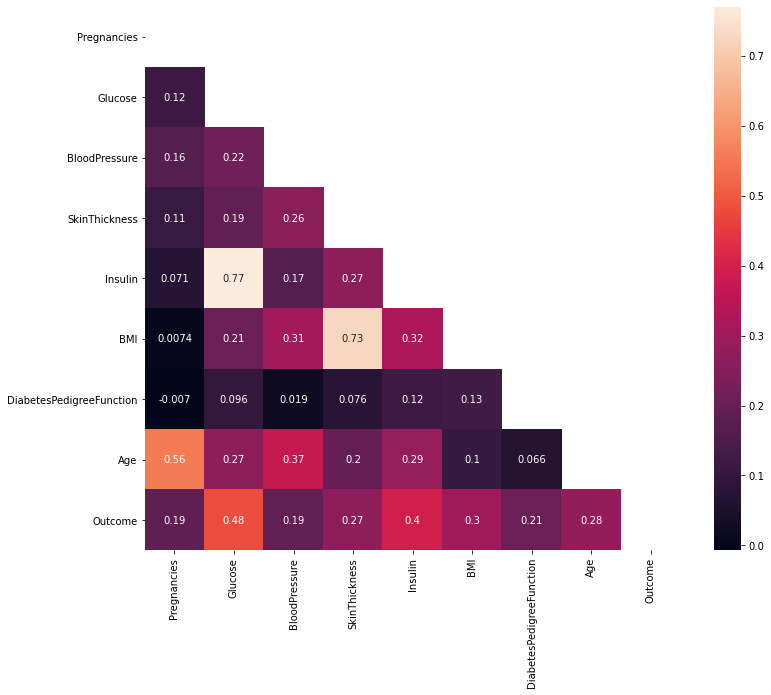

In [34]:
# dataset.corr()
show_heat_map(diabetes)

### Data Preparation

In [35]:
# drop Insulin and SkinThickness
diabetes.drop(['Insulin', 'SkinThickness'], axis=1, inplace=True)

Let's review the final features selected for modeling.

In [36]:
# get all feature names in list
final_features = [var for var in diabetes.columns[:-1]]

# print final features
print('The list of features selected for model training available is below:\n{}'.format(final_features))

The list of features selected for model training available is below:
['Pregnancies', 'Glucose', 'BloodPressure', 'BMI', 'DiabetesPedigreeFunction', 'Age']


In [37]:
# re-check the count of rows having Outcome 0 and 1 in the updated dataset
diabetes['Outcome'].value_counts()

0    478
1    242
Name: Outcome, dtype: int64

#### Split the sample space into training and test data for predictors and target variable

In [38]:
# create predictor sample space using all features excluding Outcome
X = diabetes.loc[:, diabetes.columns != 'Outcome']

# create target sample space
Y = diabetes['Outcome']

(X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, stratify=Y, test_size= 0.3, random_state=0)

# The dataset is split into two - training data and testing data
# The ratio of split is given by the parameter test_size. 0.3 means that 30% of data is chosen for test
# random_state is the seed for the random number generator for reproducible results

#### Sampling
* We noticed while doing exploratory analysis that the dataset is imbalanced towards target variable 0. The representation of 0 and that of 1 is approximately in 2:1 ratio. 

* When we trained our models on this representation of data, the accuracy of predicting 0 was satisfactorily very high however the accuracy of predicting 1 was considerably lower. This is due to the imbalanced dataset

* So, we tried sampling to make equal representations and that improved results. Predictions of 1 improved

* We tried oversampling and SMOTE sampling. Since SMOTE was giving best accuracy during model evaluation for all the modeling techniques, hence it was chosen

In [39]:
# generate synthetic samples (SMOTE)
sm = SMOTE(random_state=0)
X_train, Y_train = sm.fit_resample(X_train, Y_train)

# print the counts of training data having Outcome 0 and 1 respectively
print(Y_train.value_counts())

0    335
1    335
Name: Outcome, dtype: int64


------------------------------------------------------------------------------------------------

### Model Building & Evaluation

We have chosen below machine learning models for solving this problem:
1. Decision Tree Classifier
2. K-Nearest Neighbor (KNN) Classifier
3. Support Vector Machine (SVM) Classifier
4. Random Forest Classifier

### Model 1 - Decision Tree

In [40]:
# instantiate the DecisionTreeClassifier model using criterion gini index
dtree_model = DecisionTreeClassifier(criterion='gini', max_depth=5)

# fit the model
dtree_model.fit(X_train, Y_train)

DecisionTreeClassifier(max_depth=5)

#### Predict target variable

In [41]:
# predict test results
Y_pred_dtree = dtree_model.predict(X_test)

#### Training and test accuracy

In [42]:
# print accuracy scores on training and test set
print('Training set accuracy score \t: {:.4f}'.format(dtree_model.score(X_train, Y_train)))
print('Test set accuracy score \t: {:.4f}'.format(dtree_model.score(X_test, Y_test)))

Training set accuracy score 	: 0.8627
Test set accuracy score 	: 0.7315


#### Loss values

In [43]:
# print loss values
print('AUC-ROC score \t: {:.4f}'.format(roc_auc_score(Y_test, Y_pred_dtree)))
print('Log-loss score \t: {:.4f}'.format(log_loss(Y_test, Y_pred_dtree)))

AUC-ROC score 	: 0.7369
Log-loss score 	: 9.2744


### Performance Evaluation

#### Confusion Matrix

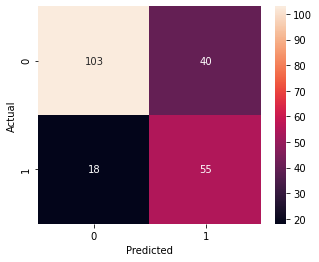

Observations:
1. True Positive (TP) = 55; (58%) of Diabetic are correctly classified by the model
2. True Negative (TN) = 103; (85%) of Non-Diabetic are correctly classified by the model
3. True Positive (FP) = 40; 40 of Non-diabetic are incorrectly classified as Diabetic
4. True Positive (FN) = 18; 18 of Diabetic are incorrectly classified as Non-diabetic


Type-I error i.e. FP = 40
Type-II error i.e. FN = 18


In [44]:
# print confusion matrix
cm_dtree = pd.crosstab(Y_test, Y_pred_dtree, rownames=['Actual'], colnames=['Predicted'])
# print('Confusion matrix: \n\n', cm_dtree)

plt.subplots(figsize=(5,4))
sns.heatmap(cm_dtree, annot=True, fmt='g')
plt.show()

tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred_dtree).ravel()
# tn, fp, fn, tp

print('Observations:')
print('1. True Positive (TP) = {}; ({:.0f}%) of Diabetic are correctly classified by the model'.format(tp, tp*100/(tp+fp)))
print('2. True Negative (TN) = {}; ({:.0f}%) of Non-Diabetic are correctly classified by the model'.format(tn, tn*100/(tn+fn))),
print('3. True Positive (FP) = {}; {} of Non-diabetic are incorrectly classified as Diabetic'.format(fp, fp))
print('4. True Positive (FN) = {}; {} of Diabetic are incorrectly classified as Non-diabetic'.format(fn, fn))
print('\n')
print('Type-I error i.e. FP = {}'.format(fp))
print('Type-II error i.e. FN = {}'.format(fn))

#### Classification Report

In [45]:
# print classification report
print('Classification report: \n 0: Non-Diabetic \n 0: 1: Diabetic \n', classification_report(Y_test, Y_pred_dtree))

Classification report: 
 0: Non-Diabetic 
 0: 1: Diabetic 
               precision    recall  f1-score   support

           0       0.85      0.72      0.78       143
           1       0.58      0.75      0.65        73

    accuracy                           0.73       216
   macro avg       0.72      0.74      0.72       216
weighted avg       0.76      0.73      0.74       216



### Model 2 - K-Nearest Neighbor

In [46]:
# instantiate the k-NN classifier model
knn_model = KNeighborsClassifier()
                                 
# fit the model
knn_model.fit(X_train, Y_train)

KNeighborsClassifier()

#### Predict target variable

In [47]:
# predict the target variable for the test data
Y_pred_knn = knn_model.predict(X_test)

#### Training and test accuracy

In [48]:
# print accuracy scores on training and test set
print('Training set accuracy score \t: {:.4f}'.format(knn_model.score(X_train, Y_train)))
print('Test set accuracy score \t: {:.4f}'.format(knn_model.score(X_test, Y_test)))

Training set accuracy score 	: 0.8582
Test set accuracy score 	: 0.7222


#### Loss value

In [49]:
# print loss values
print('AUC-ROC score \t: {:.4f}'.format(roc_auc_score(Y_test, Y_pred_knn)))
print('Log-loss score \t: {:.4f}'.format(log_loss(Y_test, Y_pred_knn)))

AUC-ROC score 	: 0.7299
Log-loss score 	: 9.5943


### Performance Evaluation

#### Confusion Matrix

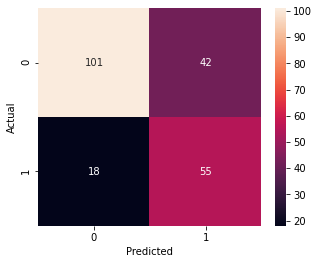

Observations:
1. True Positive (TP) = 55; (57%) of Diabetic are correctly classified by the model
2. True Negative (TN) = 101; (85%) of Non-Diabetic are correctly classified by the model
3. True Positive (FP) = 42; 42 of Non-diabetic are incorrectly classified as Diabetic
4. True Positive (FN) = 18; 18 of Diabetic are incorrectly classified as Non-diabetic


Type-I error i.e. FP = 42
Type-II error i.e. FN = 18


In [50]:
# print confusion matrix
cm_knn = pd.crosstab(Y_test, Y_pred_knn, rownames=['Actual'], colnames=['Predicted'])
# print('Confusion matrix: \n\n', cm_knn)

plt.subplots(figsize=(5,4))
sns.heatmap(cm_knn, annot=True, fmt='g')
plt.show()

tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred_knn).ravel()
# tn, fp, fn, tp

print('Observations:')
print('1. True Positive (TP) = {}; ({:.0f}%) of Diabetic are correctly classified by the model'.format(tp, tp*100/(tp+fp)))
print('2. True Negative (TN) = {}; ({:.0f}%) of Non-Diabetic are correctly classified by the model'.format(tn, tn*100/(tn+fn))),
print('3. True Positive (FP) = {}; {} of Non-diabetic are incorrectly classified as Diabetic'.format(fp, fp))
print('4. True Positive (FN) = {}; {} of Diabetic are incorrectly classified as Non-diabetic'.format(fn, fn))
print('\n')
print('Type-I error i.e. FP = {}'.format(fp))
print('Type-II error i.e. FN = {}'.format(fn))

#### Classification Report

In [51]:
# print classification report
print('Classification report: \n 0: Non-Diabetic \n 0: 1: Diabetic \n', classification_report(Y_test, Y_pred_knn))

Classification report: 
 0: Non-Diabetic 
 0: 1: Diabetic 
               precision    recall  f1-score   support

           0       0.85      0.71      0.77       143
           1       0.57      0.75      0.65        73

    accuracy                           0.72       216
   macro avg       0.71      0.73      0.71       216
weighted avg       0.75      0.72      0.73       216



### Model 3 - Support Vector Machine (SVM)

In [52]:
# instantiate the SVM classifier model
svc_model = SVC()
                                 
# fit the model
svc_model.fit(X_train, Y_train)

SVC()

#### Predict target variable

In [53]:
# predict the target variable for the test data
Y_pred_svm = svc_model.predict(X_test)

#### Training and test accuracy

In [54]:
# print accuracy scores on training and test set
print('Training set accuracy score \t: {:.4f}'.format(svc_model.score(X_train, Y_train)))
print('Test set accuracy score \t: {:.4f}'.format(svc_model.score(X_test, Y_test)))

Training set accuracy score 	: 0.8328
Test set accuracy score 	: 0.7917


#### Loss value

In [55]:
# print loss values
print('AUC-ROC score \t: {:.4f}'.format(roc_auc_score(Y_test, Y_pred_svm)))
print('Log-loss score \t: {:.4f}'.format(log_loss(Y_test, Y_pred_svm)))

AUC-ROC score 	: 0.7890
Log-loss score 	: 7.1957


### Performance Evaluation

#### Confusion Matrix

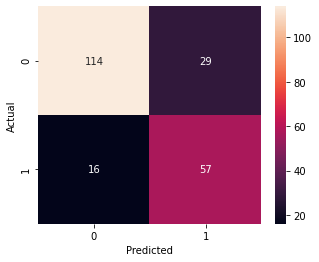

Observations:
1. True Positive (TP) = 57; (66%) of Diabetic are correctly classified by the model
2. True Negative (TN) = 114; (88%) of Non-Diabetic are correctly classified by the model
3. True Positive (FP) = 29; 29 of Non-diabetic are incorrectly classified as Diabetic
4. True Positive (FN) = 16; 16 of Diabetic are incorrectly classified as Non-diabetic


Type-I error i.e. FP = 29
Type-II error i.e. FN = 16


In [56]:
# print confusion matrix
cm_svc = pd.crosstab(Y_test, Y_pred_svm, rownames=['Actual'], colnames=['Predicted'])
# print('Confusion matrix: \n\n', cm_svc)

plt.subplots(figsize=(5,4))
sns.heatmap(cm_svc, annot=True, fmt='g')
plt.show()

tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred_svm).ravel()
# tn, fp, fn, tp

print('Observations:')
print('1. True Positive (TP) = {}; ({:.0f}%) of Diabetic are correctly classified by the model'.format(tp, tp*100/(tp+fp)))
print('2. True Negative (TN) = {}; ({:.0f}%) of Non-Diabetic are correctly classified by the model'.format(tn, tn*100/(tn+fn))),
print('3. True Positive (FP) = {}; {} of Non-diabetic are incorrectly classified as Diabetic'.format(fp, fp))
print('4. True Positive (FN) = {}; {} of Diabetic are incorrectly classified as Non-diabetic'.format(fn, fn))
print('\n')
print('Type-I error i.e. FP = {}'.format(fp))
print('Type-II error i.e. FN = {}'.format(fn))

#### Classification Report

In [57]:
# print classification report
print('Classification report: \n 0: Non-Diabetic \n 0: 1: Diabetic \n', classification_report(Y_test, Y_pred_svm))

Classification report: 
 0: Non-Diabetic 
 0: 1: Diabetic 
               precision    recall  f1-score   support

           0       0.88      0.80      0.84       143
           1       0.66      0.78      0.72        73

    accuracy                           0.79       216
   macro avg       0.77      0.79      0.78       216
weighted avg       0.80      0.79      0.80       216



### Model 4 - Random Forest Classifier

In [58]:
# instantiate the k-NN classifier model
rf_model = RandomForestClassifier()
                                 
# fit the model
rf_model.fit(X_train, Y_train)

RandomForestClassifier()

#### Predict target variable

In [59]:
# predict the target variable for the test data
Y_pred_rf = rf_model.predict(X_test)

#### Training and test accuracy

In [60]:
# print accuracy scores on training and test set
print('Training set accuracy score \t: {:.4f}'.format(rf_model.score(X_train, Y_train)))
print('Test set accuracy score \t: {:.4f}'.format(rf_model.score(X_test, Y_test)))

Training set accuracy score 	: 1.0000
Test set accuracy score 	: 0.7685


#### Loss value

In [61]:
# print loss values
print('AUC-ROC score \t: {:.4f}'.format(roc_auc_score(Y_test, Y_pred_rf)))
print('Log-loss score \t: {:.4f}'.format(log_loss(Y_test, Y_pred_rf)))

AUC-ROC score 	: 0.7346
Log-loss score 	: 7.9952


### Performance Evaluation

#### Confusion Matrix

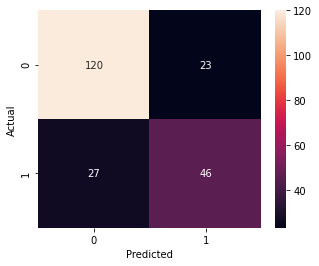

Observations:
1. True Positive (TP) = 46; (67%) of Diabetic are correctly classified by the model
2. True Negative (TN) = 120; (82%) of Non-Diabetic are correctly classified by the model
3. True Positive (FP) = 23; 23 of Non-diabetic are incorrectly classified as Diabetic
4. True Positive (FN) = 27; 27 of Diabetic are incorrectly classified as Non-diabetic


Type-I error i.e. FP = 23
Type-II error i.e. FN = 27


In [62]:
# print confusion matrix
cm_rf = pd.crosstab(Y_test, Y_pred_rf, rownames=['Actual'], colnames=['Predicted'])
# print('Confusion matrix: \n\n', cm_knn)

plt.subplots(figsize=(5,4))
sns.heatmap(cm_rf, annot=True, fmt='g')
plt.show()

tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred_rf).ravel()
# tn, fp, fn, tp

print('Observations:')
print('1. True Positive (TP) = {}; ({:.0f}%) of Diabetic are correctly classified by the model'.format(tp, tp*100/(tp+fp)))
print('2. True Negative (TN) = {}; ({:.0f}%) of Non-Diabetic are correctly classified by the model'.format(tn, tn*100/(tn+fn))),
print('3. True Positive (FP) = {}; {} of Non-diabetic are incorrectly classified as Diabetic'.format(fp, fp))
print('4. True Positive (FN) = {}; {} of Diabetic are incorrectly classified as Non-diabetic'.format(fn, fn))
print('\n')
print('Type-I error i.e. FP = {}'.format(fp))
print('Type-II error i.e. FN = {}'.format(fn))

#### Classification Report

In [63]:
# print classification report
print('Classification report: \n 0: Non-Diabetic \n 0: 1: Diabetic \n', classification_report(Y_test, Y_pred_rf))

Classification report: 
 0: Non-Diabetic 
 0: 1: Diabetic 
               precision    recall  f1-score   support

           0       0.82      0.84      0.83       143
           1       0.67      0.63      0.65        73

    accuracy                           0.77       216
   macro avg       0.74      0.73      0.74       216
weighted avg       0.77      0.77      0.77       216



### Hyper-parameter tuning of above 3 models to improve the results

Unlike having one cell for explaining each step i.e. modeling, prediction, accuracy printing, confusion matrix and classification report done above for the 3 models chosen, the code per iteration of learning, test and results is placed within a single cell to keep the document simple and logical.

#### 1. Decision Tree - iteration 2

Hyper-parameters chosen:
* criterion = entropy
* max_depth = 5

Training set accuracy score 	: 0.8269
Test set accuracy score 	: 0.7222
AUC-ROC score 	: 0.7265
Log-loss score 	: 9.5943


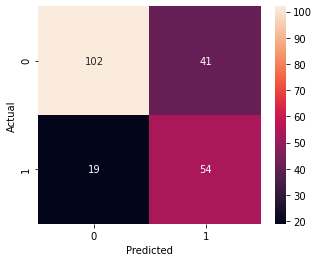

Observations:
1. True Positive (TP) = 54; (57%) of Diabetic are correctly classified by the model
2. True Negative (TN) = 102; (84%) of Non-Diabetic are correctly classified by the model
3. True Positive (FP) = 41; 41 of Non-diabetic are incorrectly classified as Diabetic
4. True Positive (FN) = 19; 19 of Diabetic are incorrectly classified as Non-diabetic


Type-I error i.e. FP = 41
Type-II error i.e. FN = 19

Classification report: 
 0: Non-Diabetic 
 0: 1: Diabetic 
               precision    recall  f1-score   support

           0       0.84      0.71      0.77       143
           1       0.57      0.74      0.64        73

    accuracy                           0.72       216
   macro avg       0.71      0.73      0.71       216
weighted avg       0.75      0.72      0.73       216



In [64]:
# re-run decision tree classifier with updated hyper-parameters

# instantiate the DecisionTreeClassifier model
dtree_model = DecisionTreeClassifier(criterion='entropy', max_depth=5)

# fit the model
dtree_model.fit(X_train, Y_train)

# predict test results
Y_pred_dtree = dtree_model.predict(X_test)

# print accuracy scores on training and test set
print('Training set accuracy score \t: {:.4f}'.format(dtree_model.score(X_train, Y_train)))
print('Test set accuracy score \t: {:.4f}'.format(dtree_model.score(X_test, Y_test)))

# print loss values
print('AUC-ROC score \t: {:.4f}'.format(roc_auc_score(Y_test, Y_pred_dtree)))
print('Log-loss score \t: {:.4f}'.format(log_loss(Y_test, Y_pred_dtree)))

# print confusion matrix
cm_dtree = pd.crosstab(Y_test, Y_pred_dtree, rownames=['Actual'], colnames=['Predicted'])
plt.subplots(figsize=(5,4))
sns.heatmap(cm_dtree, annot=True, fmt='g')
plt.show()

tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred_dtree).ravel()
print('Observations:')
print('1. True Positive (TP) = {}; ({:.0f}%) of Diabetic are correctly classified by the model'.format(tp, tp*100/(tp+fp)))
print('2. True Negative (TN) = {}; ({:.0f}%) of Non-Diabetic are correctly classified by the model'.format(tn, tn*100/(tn+fn))),
print('3. True Positive (FP) = {}; {} of Non-diabetic are incorrectly classified as Diabetic'.format(fp, fp))
print('4. True Positive (FN) = {}; {} of Diabetic are incorrectly classified as Non-diabetic'.format(fn, fn))
print('\n')
print('Type-I error i.e. FP = {}'.format(fp))
print('Type-II error i.e. FN = {}'.format(fn))

# print classification report
print('\nClassification report: \n 0: Non-Diabetic \n 0: 1: Diabetic \n', classification_report(Y_test, Y_pred_dtree))

#### 2. Decision Tree Classifier - iteration 3

Hyper-parameters chosen:
* criterion = gini
* max_depth = 5
* random_state = multiple values chosen iteratively

Training set accuracy score 	: 0.8269
Test set accuracy score 	: 0.7176
AUC-ROC score 	: 0.7197
Log-loss score 	: 9.7542


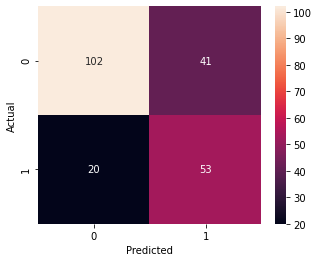

Observations:
1. True Positive (TP) = 53; (56%) of Diabetic are correctly classified by the model
2. True Negative (TN) = 102; (84%) of Non-Diabetic are correctly classified by the model
3. True Positive (FP) = 41; 41 of Non-diabetic are incorrectly classified as Diabetic
4. True Positive (FN) = 20; 20 of Diabetic are incorrectly classified as Non-diabetic


Type-I error i.e. FP = 41
Type-II error i.e. FN = 20

Classification report: 
 0: Non-Diabetic 
 0: 1: Diabetic 
               precision    recall  f1-score   support

           0       0.84      0.71      0.77       143
           1       0.56      0.73      0.63        73

    accuracy                           0.72       216
   macro avg       0.70      0.72      0.70       216
weighted avg       0.74      0.72      0.72       216



In [65]:
# re-run decision tree classifier with updated hyper-parameters

# instantiate the DecisionTreeClassifier model
dtree_model = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)

# fit the model
dtree_model.fit(X_train, Y_train)

# predict test results
Y_pred_dtree = dtree_model.predict(X_test)

# print accuracy scores on training and test set
print('Training set accuracy score \t: {:.4f}'.format(dtree_model.score(X_train, Y_train)))
print('Test set accuracy score \t: {:.4f}'.format(dtree_model.score(X_test, Y_test)))

# print loss values
print('AUC-ROC score \t: {:.4f}'.format(roc_auc_score(Y_test, Y_pred_dtree)))
print('Log-loss score \t: {:.4f}'.format(log_loss(Y_test, Y_pred_dtree)))

# print confusion matrix
cm_dtree = pd.crosstab(Y_test, Y_pred_dtree, rownames=['Actual'], colnames=['Predicted'])
plt.subplots(figsize=(5,4))
sns.heatmap(cm_dtree, annot=True, fmt='g')
plt.show()

tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred_dtree).ravel()
print('Observations:')
print('1. True Positive (TP) = {}; ({:.0f}%) of Diabetic are correctly classified by the model'.format(tp, tp*100/(tp+fp)))
print('2. True Negative (TN) = {}; ({:.0f}%) of Non-Diabetic are correctly classified by the model'.format(tn, tn*100/(tn+fn))),
print('3. True Positive (FP) = {}; {} of Non-diabetic are incorrectly classified as Diabetic'.format(fp, fp))
print('4. True Positive (FN) = {}; {} of Diabetic are incorrectly classified as Non-diabetic'.format(fn, fn))
print('\n')
print('Type-I error i.e. FP = {}'.format(fp))
print('Type-II error i.e. FN = {}'.format(fn))

# print classification report
print('\nClassification report: \n 0: Non-Diabetic \n 0: 1: Diabetic \n', classification_report(Y_test, Y_pred_dtree))

#### 3. Decision Tree Classifier - iteration 4

Hyper-parameters chosen:
1. criterion = gini
2. max_depth = 7, then 8, 9
3. random_state = multiple values chosen iteratively

Training set accuracy score 	: 0.9552
Test set accuracy score 	: 0.7176
AUC-ROC score 	: 0.6828
Log-loss score 	: 9.7541


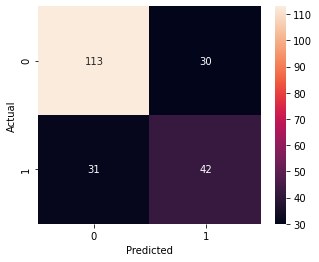

Observations:
1. True Positive (TP) = 42; (58%) of Diabetic are correctly classified by the model
2. True Negative (TN) = 113; (78%) of Non-Diabetic are correctly classified by the model
3. True Positive (FP) = 30; 30 of Non-diabetic are incorrectly classified as Diabetic
4. True Positive (FN) = 31; 31 of Diabetic are incorrectly classified as Non-diabetic


Type-I error i.e. FP = 30
Type-II error i.e. FN = 31

Classification report: 
 0: Non-Diabetic 
 0: 1: Diabetic 
               precision    recall  f1-score   support

           0       0.78      0.79      0.79       143
           1       0.58      0.58      0.58        73

    accuracy                           0.72       216
   macro avg       0.68      0.68      0.68       216
weighted avg       0.72      0.72      0.72       216



In [66]:
# re-run decision tree classifier with updated hyper-parameters

# instantiate the DecisionTreeClassifier model
dtree_model = DecisionTreeClassifier(criterion='entropy', max_depth=9, random_state=42)

# fit the model
dtree_model.fit(X_train, Y_train)

# predict test results
Y_pred_dtree = dtree_model.predict(X_test)

# print accuracy scores on training and test set
print('Training set accuracy score \t: {:.4f}'.format(dtree_model.score(X_train, Y_train)))
print('Test set accuracy score \t: {:.4f}'.format(dtree_model.score(X_test, Y_test)))

# print loss values
print('AUC-ROC score \t: {:.4f}'.format(roc_auc_score(Y_test, Y_pred_dtree)))
print('Log-loss score \t: {:.4f}'.format(log_loss(Y_test, Y_pred_dtree)))

# print confusion matrix
cm_dtree = pd.crosstab(Y_test, Y_pred_dtree, rownames=['Actual'], colnames=['Predicted'])
plt.subplots(figsize=(5,4))
sns.heatmap(cm_dtree, annot=True, fmt='g')
plt.show()

tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred_dtree).ravel()
print('Observations:')
print('1. True Positive (TP) = {}; ({:.0f}%) of Diabetic are correctly classified by the model'.format(tp, tp*100/(tp+fp)))
print('2. True Negative (TN) = {}; ({:.0f}%) of Non-Diabetic are correctly classified by the model'.format(tn, tn*100/(tn+fn))),
print('3. True Positive (FP) = {}; {} of Non-diabetic are incorrectly classified as Diabetic'.format(fp, fp))
print('4. True Positive (FN) = {}; {} of Diabetic are incorrectly classified as Non-diabetic'.format(fn, fn))
print('\n')
print('Type-I error i.e. FP = {}'.format(fp))
print('Type-II error i.e. FN = {}'.format(fn))

# print classification report
print('\nClassification report: \n 0: Non-Diabetic \n 0: 1: Diabetic \n', classification_report(Y_test, Y_pred_dtree))

#### 4. K-Nearest Neighbor - iteration 2

Hyper-parameters chosen:
* n_neighbors = 6,7,8,9,10,11,12,13,14,15

Training set accuracy score 	: 0.8269
Test set accuracy score 	: 0.7685
AUC-ROC score 	: 0.7648
Log-loss score 	: 7.9952


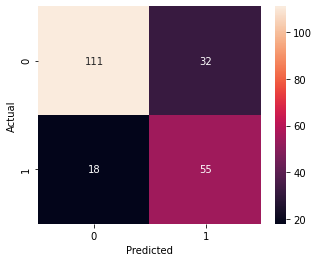

Observations:
1. True Positive (TP) = 55; (63%) of Diabetic are correctly classified by the model
2. True Negative (TN) = 111; (86%) of Non-Diabetic are correctly classified by the model
3. True Positive (FP) = 32; 32 of Non-diabetic are incorrectly classified as Diabetic
4. True Positive (FN) = 18; 18 of Diabetic are incorrectly classified as Non-diabetic


Type-I error i.e. FP = 32
Type-II error i.e. FN = 18

Classification report: 
 0: Non-Diabetic 
 0: 1: Diabetic 
               precision    recall  f1-score   support

           0       0.86      0.78      0.82       143
           1       0.63      0.75      0.69        73

    accuracy                           0.77       216
   macro avg       0.75      0.76      0.75       216
weighted avg       0.78      0.77      0.77       216



In [67]:
# re-run kNN classifier with updated hyper-parameters

# instantiate the k-NN classifier model
knn_model = KNeighborsClassifier(n_neighbors=10)
                                 
# fit the model
knn_model.fit(X_train, Y_train)

# predict the target variable for the test data
Y_pred_knn = knn_model.predict(X_test)

# print accuracy scores on training and test set
print('Training set accuracy score \t: {:.4f}'.format(knn_model.score(X_train, Y_train)))
print('Test set accuracy score \t: {:.4f}'.format(knn_model.score(X_test, Y_test)))

# print loss values
print('AUC-ROC score \t: {:.4f}'.format(roc_auc_score(Y_test, Y_pred_knn)))
print('Log-loss score \t: {:.4f}'.format(log_loss(Y_test, Y_pred_knn)))

# print confusion matrix
cm_knn = pd.crosstab(Y_test, Y_pred_knn, rownames=['Actual'], colnames=['Predicted'])
plt.subplots(figsize=(5,4))
sns.heatmap(cm_knn, annot=True, fmt='g')
plt.show()

tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred_knn).ravel()
print('Observations:')
print('1. True Positive (TP) = {}; ({:.0f}%) of Diabetic are correctly classified by the model'.format(tp, tp*100/(tp+fp)))
print('2. True Negative (TN) = {}; ({:.0f}%) of Non-Diabetic are correctly classified by the model'.format(tn, tn*100/(tn+fn))),
print('3. True Positive (FP) = {}; {} of Non-diabetic are incorrectly classified as Diabetic'.format(fp, fp))
print('4. True Positive (FN) = {}; {} of Diabetic are incorrectly classified as Non-diabetic'.format(fn, fn))
print('\n')
print('Type-I error i.e. FP = {}'.format(fp))
print('Type-II error i.e. FN = {}'.format(fn))

# print classification report
print('\nClassification report: \n 0: Non-Diabetic \n 0: 1: Diabetic \n', classification_report(Y_test, Y_pred_knn))

#### 5. K-Nearest Neighbor - iteration 3

Hyper-parameters chosen:
* p = 3,4,5
* n_neighbors = 6 to 15 - values chosen iteratively

Training set accuracy score 	: 0.8284
Test set accuracy score 	: 0.7546
AUC-ROC score 	: 0.7510
Log-loss score 	: 8.4749


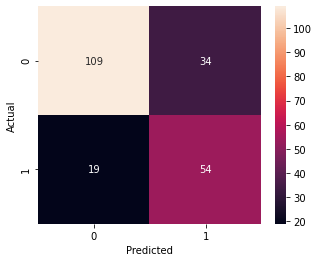

Observations:
1. True Positive (TP) = 54; (61%) of Diabetic are correctly classified by the model
2. True Negative (TN) = 109; (85%) of Non-Diabetic are correctly classified by the model
3. True Positive (FP) = 34; 34 of Non-diabetic are incorrectly classified as Diabetic
4. True Positive (FN) = 19; 19 of Diabetic are incorrectly classified as Non-diabetic


Type-I error i.e. FP = 34
Type-II error i.e. FN = 19

Classification report: 
 0: Non-Diabetic 
 0: 1: Diabetic 
               precision    recall  f1-score   support

           0       0.85      0.76      0.80       143
           1       0.61      0.74      0.67        73

    accuracy                           0.75       216
   macro avg       0.73      0.75      0.74       216
weighted avg       0.77      0.75      0.76       216



In [68]:
# re-run kNN classifier with updated hyper-parameters

# instantiate the k-NN classifier model
knn_model = KNeighborsClassifier(p=3, n_neighbors=10)
                                 
# fit the model
knn_model.fit(X_train, Y_train)

# predict the target variable for the test data
Y_pred_knn = knn_model.predict(X_test)

# print accuracy scores on training and test set
print('Training set accuracy score \t: {:.4f}'.format(knn_model.score(X_train, Y_train)))
print('Test set accuracy score \t: {:.4f}'.format(knn_model.score(X_test, Y_test)))

# print loss values
print('AUC-ROC score \t: {:.4f}'.format(roc_auc_score(Y_test, Y_pred_knn)))
print('Log-loss score \t: {:.4f}'.format(log_loss(Y_test, Y_pred_knn)))

# print confusion matrix
cm_knn = pd.crosstab(Y_test, Y_pred_knn, rownames=['Actual'], colnames=['Predicted'])
plt.subplots(figsize=(5,4))
sns.heatmap(cm_knn, annot=True, fmt='g')
plt.show()

tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred_knn).ravel()
print('Observations:')
print('1. True Positive (TP) = {}; ({:.0f}%) of Diabetic are correctly classified by the model'.format(tp, tp*100/(tp+fp)))
print('2. True Negative (TN) = {}; ({:.0f}%) of Non-Diabetic are correctly classified by the model'.format(tn, tn*100/(tn+fn))),
print('3. True Positive (FP) = {}; {} of Non-diabetic are incorrectly classified as Diabetic'.format(fp, fp))
print('4. True Positive (FN) = {}; {} of Diabetic are incorrectly classified as Non-diabetic'.format(fn, fn))
print('\n')
print('Type-I error i.e. FP = {}'.format(fp))
print('Type-II error i.e. FN = {}'.format(fn))

# print classification report
print('\nClassification report: \n 0: Non-Diabetic \n 0: 1: Diabetic \n', classification_report(Y_test, Y_pred_knn))

#### 6. SVM Classifier - iteration 2

Hyper-parameters chosen:
* degree = 2,4,5...10 - values chosen iteratively

Training set accuracy score 	: 0.8328
Test set accuracy score 	: 0.7917
AUC-ROC score 	: 0.7890
Log-loss score 	: 7.1957


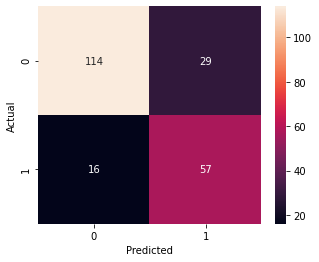

Observations:
1. True Positive (TP) = 57; (66%) of Diabetic are correctly classified by the model
2. True Negative (TN) = 114; (88%) of Non-Diabetic are correctly classified by the model
3. True Positive (FP) = 29; 29 of Non-diabetic are incorrectly classified as Diabetic
4. True Positive (FN) = 16; 16 of Diabetic are incorrectly classified as Non-diabetic


Type-I error i.e. FP = 29
Type-II error i.e. FN = 16

Classification report: 
 0: Non-Diabetic 
 0: 1: Diabetic 
               precision    recall  f1-score   support

           0       0.88      0.80      0.84       143
           1       0.66      0.78      0.72        73

    accuracy                           0.79       216
   macro avg       0.77      0.79      0.78       216
weighted avg       0.80      0.79      0.80       216



In [69]:
# re-run SVM classifier with updated hyper-parameters

# instantiate the SVM classifier model
svc_model = SVC(degree=10)
                                 
# fit the model
svc_model.fit(X_train, Y_train)

# predict the target variable for the test data
Y_pred_svc = svc_model.predict(X_test)

# print accuracy scores on training and test set
print('Training set accuracy score \t: {:.4f}'.format(svc_model.score(X_train, Y_train)))
print('Test set accuracy score \t: {:.4f}'.format(svc_model.score(X_test, Y_test)))

# print loss values
print('AUC-ROC score \t: {:.4f}'.format(roc_auc_score(Y_test, Y_pred_svc)))
print('Log-loss score \t: {:.4f}'.format(log_loss(Y_test, Y_pred_svc)))

# print confusion matrix
cm_svc = pd.crosstab(Y_test, Y_pred_svc, rownames=['Actual'], colnames=['Predicted'])
plt.subplots(figsize=(5,4))
sns.heatmap(cm_svc, annot=True, fmt='g')
plt.show()

tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred_svc).ravel()
print('Observations:')
print('1. True Positive (TP) = {}; ({:.0f}%) of Diabetic are correctly classified by the model'.format(tp, tp*100/(tp+fp)))
print('2. True Negative (TN) = {}; ({:.0f}%) of Non-Diabetic are correctly classified by the model'.format(tn, tn*100/(tn+fn))),
print('3. True Positive (FP) = {}; {} of Non-diabetic are incorrectly classified as Diabetic'.format(fp, fp))
print('4. True Positive (FN) = {}; {} of Diabetic are incorrectly classified as Non-diabetic'.format(fn, fn))
print('\n')
print('Type-I error i.e. FP = {}'.format(fp))
print('Type-II error i.e. FN = {}'.format(fn))

# print classification report
print('\nClassification report: \n 0: Non-Diabetic \n 0: 1: Diabetic \n', classification_report(Y_test, Y_pred_svc))

#### 6. SVM Classifier - iteration 3

Hyper-parameters chosen:

* use the GridSearchCV optimizer to chose the best parameters

In [70]:
# define parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}

# find the best parameters using GridSearchCV
grid = GridSearchCV(SVC(), param_grid)
 
# fitting the model for grid search
grid.fit(X_train, Y_train)

# view best estimating parameters
print(grid.best_estimator_)

SVC(C=1000, gamma=1)


Training set accuracy score 	: 0.8985
Test set accuracy score 	: 0.7083
AUC-ROC score 	: 0.6758
Log-loss score 	: 10.0739


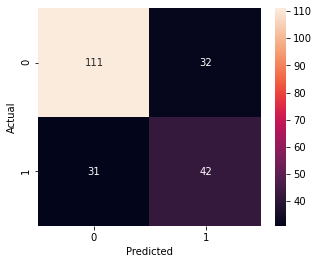

Observations:
1. True Positive (TP) = 42; (57%) of Diabetic are correctly classified by the model
2. True Negative (TN) = 111; (78%) of Non-Diabetic are correctly classified by the model
3. True Positive (FP) = 32; 32 of Non-diabetic are incorrectly classified as Diabetic
4. True Positive (FN) = 31; 31 of Diabetic are incorrectly classified as Non-diabetic


Type-I error i.e. FP = 32
Type-II error i.e. FN = 31

Classification report: 
 0: Non-Diabetic 
 0: 1: Diabetic 
               precision    recall  f1-score   support

           0       0.78      0.78      0.78       143
           1       0.57      0.58      0.57        73

    accuracy                           0.71       216
   macro avg       0.67      0.68      0.68       216
weighted avg       0.71      0.71      0.71       216



In [71]:
# re-run SVM classifier with updated hyper-parameters

# instantiate the SVM classifier model
svc_model = SVC(C=1000, gamma=1)
                                 
# fit the model
svc_model.fit(X_train, Y_train)

# predict the target variable for the test data
Y_pred_svc = svc_model.predict(X_test)

# print accuracy scores on training and test set
print('Training set accuracy score \t: {:.4f}'.format(svc_model.score(X_train, Y_train)))
print('Test set accuracy score \t: {:.4f}'.format(svc_model.score(X_test, Y_test)))

# print loss values
print('AUC-ROC score \t: {:.4f}'.format(roc_auc_score(Y_test, Y_pred_svc)))
print('Log-loss score \t: {:.4f}'.format(log_loss(Y_test, Y_pred_svc)))

# print confusion matrix
cm_svc = pd.crosstab(Y_test, Y_pred_svc, rownames=['Actual'], colnames=['Predicted'])
plt.subplots(figsize=(5,4))
sns.heatmap(cm_svc, annot=True, fmt='g')
plt.show()

tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred_svc).ravel()
print('Observations:')
print('1. True Positive (TP) = {}; ({:.0f}%) of Diabetic are correctly classified by the model'.format(tp, tp*100/(tp+fp)))
print('2. True Negative (TN) = {}; ({:.0f}%) of Non-Diabetic are correctly classified by the model'.format(tn, tn*100/(tn+fn))),
print('3. True Positive (FP) = {}; {} of Non-diabetic are incorrectly classified as Diabetic'.format(fp, fp))
print('4. True Positive (FN) = {}; {} of Diabetic are incorrectly classified as Non-diabetic'.format(fn, fn))
print('\n')
print('Type-I error i.e. FP = {}'.format(fp))
print('Type-II error i.e. FN = {}'.format(fn))

# print classification report
print('\nClassification report: \n 0: Non-Diabetic \n 0: 1: Diabetic \n', classification_report(Y_test, Y_pred_svc))

#### 7. Random Forest Classifier - iteration 2

Hyper-parameters chosen:
* n_estimators = 100, 150, 200, 500, 1000

Training set accuracy score 	: 1.0000
Test set accuracy score 	: 0.7824
AUC-ROC score 	: 0.7552
Log-loss score 	: 7.5155


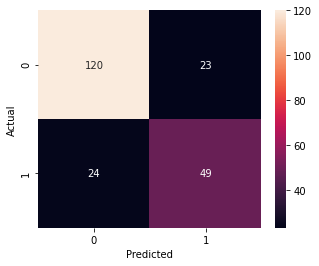

Observations:
1. True Positive (TP) = 49; (68%) of Diabetic are correctly classified by the model
2. True Negative (TN) = 120; (83%) of Non-Diabetic are correctly classified by the model
3. True Positive (FP) = 23; 23 of Non-diabetic are incorrectly classified as Diabetic
4. True Positive (FN) = 24; 24 of Diabetic are incorrectly classified as Non-diabetic


Type-I error i.e. FP = 23
Type-II error i.e. FN = 24

Classification report: 
 0: Non-Diabetic 
 0: 1: Diabetic 
               precision    recall  f1-score   support

           0       0.83      0.84      0.84       143
           1       0.68      0.67      0.68        73

    accuracy                           0.78       216
   macro avg       0.76      0.76      0.76       216
weighted avg       0.78      0.78      0.78       216



In [72]:
# re-run Random Forest classifier with updated hyper-parameters

# instantiate the Random Forest classifier model
rf_model = RandomForestClassifier(n_estimators=200)
                                 
# fit the model
rf_model.fit(X_train, Y_train)

# predict the target variable for the test data
Y_pred_rf = rf_model.predict(X_test)

# print accuracy scores on training and test set
print('Training set accuracy score \t: {:.4f}'.format(rf_model.score(X_train, Y_train)))
print('Test set accuracy score \t: {:.4f}'.format(rf_model.score(X_test, Y_test)))

# print loss values
print('AUC-ROC score \t: {:.4f}'.format(roc_auc_score(Y_test, Y_pred_rf)))
print('Log-loss score \t: {:.4f}'.format(log_loss(Y_test, Y_pred_rf)))

# print confusion matrix
cm_rf = pd.crosstab(Y_test, Y_pred_rf, rownames=['Actual'], colnames=['Predicted'])
plt.subplots(figsize=(5,4))
sns.heatmap(cm_rf, annot=True, fmt='g')
plt.show()

tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred_rf).ravel()
print('Observations:')
print('1. True Positive (TP) = {}; ({:.0f}%) of Diabetic are correctly classified by the model'.format(tp, tp*100/(tp+fp)))
print('2. True Negative (TN) = {}; ({:.0f}%) of Non-Diabetic are correctly classified by the model'.format(tn, tn*100/(tn+fn))),
print('3. True Positive (FP) = {}; {} of Non-diabetic are incorrectly classified as Diabetic'.format(fp, fp))
print('4. True Positive (FN) = {}; {} of Diabetic are incorrectly classified as Non-diabetic'.format(fn, fn))
print('\n')
print('Type-I error i.e. FP = {}'.format(fp))
print('Type-II error i.e. FN = {}'.format(fn))

# print classification report
print('\nClassification report: \n 0: Non-Diabetic \n 0: 1: Diabetic \n', classification_report(Y_test, Y_pred_rf))

#### 7. Random Forest Classifier - iteration 3,4,5,6,7,8,9

Hyper-parameters chosen:
* n_estimators = 200
* random_state=42, 100, 150 - values changed iteratively
* criterion='gini', 'entropy' - values changed iteratively
* max_depth=None

Training set accuracy score 	: 1.0000
Test set accuracy score 	: 0.7963
AUC-ROC score 	: 0.7724
Log-loss score 	: 7.0358


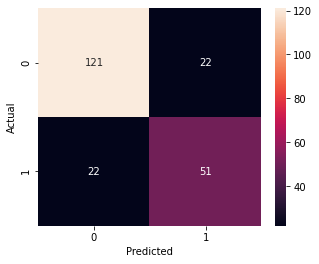

Observations:
1. True Positive (TP) = 51; (70%) of Diabetic are correctly classified by the model
2. True Negative (TN) = 121; (85%) of Non-Diabetic are correctly classified by the model
3. True Positive (FP) = 22; 22 of Non-diabetic are incorrectly classified as Diabetic
4. True Positive (FN) = 22; 22 of Diabetic are incorrectly classified as Non-diabetic


Type-I error i.e. FP = 22
Type-II error i.e. FN = 22

Classification report: 
 0: Non-Diabetic 
 0: 1: Diabetic 
               precision    recall  f1-score   support

           0       0.85      0.85      0.85       143
           1       0.70      0.70      0.70        73

    accuracy                           0.80       216
   macro avg       0.77      0.77      0.77       216
weighted avg       0.80      0.80      0.80       216



In [73]:
# re-run Random Forest classifier with updated hyper-parameters

# instantiate the Random Forest classifier model
rf_model = RandomForestClassifier(n_estimators=200, random_state=150, criterion='gini', max_depth=20)
                                 
# fit the model
rf_model.fit(X_train, Y_train)

# predict the target variable for the test data
Y_pred_rf = rf_model.predict(X_test)

# print accuracy scores on training and test set
print('Training set accuracy score \t: {:.4f}'.format(rf_model.score(X_train, Y_train)))
print('Test set accuracy score \t: {:.4f}'.format(rf_model.score(X_test, Y_test)))

# print loss values
print('AUC-ROC score \t: {:.4f}'.format(roc_auc_score(Y_test, Y_pred_rf)))
print('Log-loss score \t: {:.4f}'.format(log_loss(Y_test, Y_pred_rf)))

# print confusion matrix
cm_rf = pd.crosstab(Y_test, Y_pred_rf, rownames=['Actual'], colnames=['Predicted'])
plt.subplots(figsize=(5,4))
sns.heatmap(cm_rf, annot=True, fmt='g')
plt.show()

tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred_rf).ravel()
print('Observations:')
print('1. True Positive (TP) = {}; ({:.0f}%) of Diabetic are correctly classified by the model'.format(tp, tp*100/(tp+fp)))
print('2. True Negative (TN) = {}; ({:.0f}%) of Non-Diabetic are correctly classified by the model'.format(tn, tn*100/(tn+fn))),
print('3. True Positive (FP) = {}; {} of Non-diabetic are incorrectly classified as Diabetic'.format(fp, fp))
print('4. True Positive (FN) = {}; {} of Diabetic are incorrectly classified as Non-diabetic'.format(fn, fn))
print('\n')
print('Type-I error i.e. FP = {}'.format(fp))
print('Type-II error i.e. FN = {}'.format(fn))

# print classification report
print('\nClassification report: \n 0: Non-Diabetic \n 0: 1: Diabetic \n', classification_report(Y_test, Y_pred_rf))

------------------------------------------------------------------------------------------------

### Conclusion

#### Decision Tree:
This model is the least successful model and it predicts Outcome 1 (i.e. Diabetic) with the lowest precision. The log loss (**9.27**) is also high as compared to the other two models. The best overall accuracy achieved from this model was **73%** (of which **58%** of Outcome 1 and **85%** of Outcome 0). The difference between training and test accuracy **~13%** is also high as compared to other models.

#### k-Nearest Neighbor:
This model worked better as compared to the Decision Tree classifier. The log loss value of this model was **7.99** which is better than that of Decision Tree. The overall accuracy was **77%** (of which **63%** of Outcome 1 and **86%** of Outcome 0) is also better as compared to Decision Tree.

#### Support Vector Machine:
This model worked the best out of all of our models giving the highest accuracy and least log loss. It is also predicting Outcome 1 at significant levels compared to the other two. It has log loss of **7.03** and overall accuracy of **79%** which includes **66%** and **88%** precision of Outcome 1 and 0 respectively. The training and test set accuracy are also very close.

The type I and type II errors were also least for SVM model among the four which we used.

#### Random Forest:
This model has better training and test accuracy as compared to Decision Tree and k-NN models and least log loss. It is also predicting Outcome 1 at significant levels compared to the other three. It has log loss of **7.19** and overall accuracy of **80%** which includes **70%** and **85%** precision of Outcome 1 and 0 respectively. However, the training and test set accuracies have very high difference of ~**20%**. So, the model is inconsistent in terms of accuracy.

#### Training & Test Errors:

|Classifier|Train Error|Test Error|Log Loss|AUC-ROC
|:---|:---|:---|:---|:---|
|**Decision Tree**|13.7%|26.8%|9.27|0.73|
|**k-Nearest Neighbor**|17.3%|23.2%|7.99|0.76|
|**Support Vector Machine**|16.7%|20.8%|7.19|0.79|
|**Random Forest**|0%|20.4%|7.03|0.77|

- Train Error = (1 - Training accuracy)*100
- Test Error = (1 - Test accuracy)*100

##### The best 2 models are Random Forest and SVM. Based on above observations, the overall accuracy and precision of Random Forest Model is better than SVM, however the accuracy of training and test set are not consistent (difference ~20% is very high) for this model, and also the AUC (i.e. area under TPR and FPR) is low compared to SVM. So, SVM model is delivering the best prediction for the given problem.